# Deep Neural Network for MNIST Classification

The dataset is called MNIST and refers to handwritten digit recognition. You can find more about it on Yann LeCun's website (Director of AI Research, Facebook).

The dataset provides 70,000 images (28x28 pixels) of handwritten digits (1 digit per image).

The goal is to write an algorithm that detects which digit is written. Since there are only 10 digits (0, 1, 2, 3, 4, 5, 6, 7, 8, 9), this is a classification problem with 10 classes.

Our goal would be to build a neural network with hidden layers.

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import tensorflow_datasets as tfds

## Data Preprocessing

In [117]:
# Load the data from tfds
mnist_datasets, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

# with_info=True will also provide us with a tuple containing information about the version, features, number of samples
# as_supervised=True will load the dataset in a 2-tuple structure (input, target)

In [118]:
# Check the info of the mnist datasets
mnist_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='C:\\Users\\josep\\tensorflow_datasets\\mnist\\3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [119]:
# Check the mnist datasets
mnist_datasets

{'train': <_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'test': <_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

In [120]:
# once we have loaded the dataset, we can easily extract the training and testing dataset
mnist_train, mnist_test = mnist_datasets['train'], mnist_datasets['test']

In [121]:
# total number of training data in the mnist datasets
tf.cast(mnist_info.splits['train'].num_examples, tf.int64)

<tf.Tensor: shape=(), dtype=int64, numpy=60000>

By default, TF has training and testing datasets but no validation sets,
thus we must split it on our own

In [123]:
# we start by defining the number of validation samples as a % of the train samples
num_validation_samples = 0.1 * mnist_info.splits["train"].num_examples
# let's cast this number to an integer, as a float may cause an error along the way
num_validation_samples = tf.cast(num_validation_samples, tf.int64)
num_validation_samples

<tf.Tensor: shape=(), dtype=int64, numpy=6000>

In [124]:
# let's also store the number of test samples in a dedicated variable
num_test_samples = tf.cast(mnist_info.splits['test'].num_examples, tf.int64)
num_test_samples

<tf.Tensor: shape=(), dtype=int64, numpy=10000>

Normally, we would like to scale our data in some way to make the result more numerically stable. \
In this case we will simply prefer to have inputs between 0 and 1.\
The method dataset.map(custom_function) allows us to apply a custom transformation to a given dataset

In [126]:
# let's define a function called: scale, that will take an MNIST image and its label
def scale(image, label):
    image = tf.cast(image, tf.float32) #float values
    # since the possible values for the inputs are 0 to 255 (256 different shades of grey)
    # if we divide each element by 255, we would get the desired result -> all elements will be between 0 and 1 
    image /= 255.

    return image, label

# we will apply the scaling transformation on the mnist_train and store it as both train and validation data
scaled_train_and_validation_data = mnist_train.map(scale)
# same thing for the test data so it has the same magnitude as the train and validation
scaled_test_data = mnist_test.map(scale)

We will also shuffle the combine train and validation data. \
There is no need to shuffle the test data, because we won't be training on it.

This BUFFER_SIZE parameter is here for cases when we're dealing with enormous datasets,
then we can't shuffle the whole dataset in one go because we can't fit it all in memory, so instead TF only stores BUFFER_SIZE samples in memory at a time and shuffles them.
* if BUFFER_SIZE = 1 -- no shuffling will actually happen
* if BUFFER_SIZE >= num samples -- shuffling is uniform
* BUFFER_SIZE in between -- a computational optimization to approximate uniform shuffling

In [128]:
BUFFER_SIZE = 10000

# there is a shuffle method readily available and we just need to specify the buffer size
shuffled_train_and_validation_data = scaled_train_and_validation_data.shuffle(BUFFER_SIZE)

# once we have scaled and shuffled the data, we can proceed to actually extracting the train and validation
# our validation data would be equal to 10% of the training set, which we've already calculated
# we use the .take() method to take that many samples
validation_data = shuffled_train_and_validation_data.take(num_validation_samples)

# similarly, the train_data is everything else, so we skip as many samples as there are in the validation dataset
train_data = shuffled_train_and_validation_data.skip(num_validation_samples)

# determine the batch size
BATCH_SIZE = 100

# batch the data
train_data = train_data.batch(BATCH_SIZE)

validation_data = validation_data.batch(num_validation_samples)

test_data = scaled_test_data.batch(num_test_samples)

# takes next batch (it is the only batch)
# because as_supervized=True, we've got a 2-tuple structure
validation_inputs, validation_targets = next(iter(validation_data))

In [129]:
# Batched train dataset
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Model

### DNN using Tensorflow

In [131]:
INPUT_SIZE = 784
HIDDEN_LAYER_SIZE = 50
OUTPUT_SIZE = 10


# define how the model will look like
model = tf.keras.Sequential([
    # the first layer (the input layer)
    # each observation is 28x28x1 pixels, therefore it is a tensor of rank 3, we must flatten the images
    # there is a convenient method 'Flatten' that simply takes our 28x28x1 tensor and orders it into a (None,) 
    # or (28x28x1,) = (784,) vector
    # this allows us to actually create a feed forward neural network
    tf.keras.layers.Flatten(input_shape = (28, 28, 1)),

    # Hidden layers
    tf.keras.layers.Dense(HIDDEN_LAYER_SIZE, activation="relu"), # 1st
    tf.keras.layers.Dense(HIDDEN_LAYER_SIZE, activation="relu"), # 2nd

    # the final layer is no different, we just make sure to activate it with softmax
    tf.keras.layers.Dense(OUTPUT_SIZE, activation="softmax")
])

## Optimization and Loss function

we define the optimizer we'd like to use, the loss function, and the metrics we are interested in obtaining at each iteration

In [133]:
model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=["accuracy"])

## Training

Here we are going to train our model :)

In [135]:
# specify the number of epochs
EPOCHS = 10
# We would like to see the metrics presented out per epochs, also for future uses,
# we would like to have it saved so we use custom callback that records them during training
class MetricsHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
    
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))

# Create an instance of the callback
metrics_history = MetricsHistory()

# we fit the model, specifying the training data, the total number of epochs
# and the validation data we just created ourselves in the format: (inputs,targets)
model.fit(train_data, epochs=EPOCHS, validation_data=(validation_inputs, validation_targets), verbose=2, callbacks=[metrics_history])

Epoch 1/10
540/540 - 2s - loss: 0.4142 - accuracy: 0.8831 - val_loss: 0.2072 - val_accuracy: 0.9405 - 2s/epoch - 3ms/step
Epoch 2/10
540/540 - 1s - loss: 0.1849 - accuracy: 0.9467 - val_loss: 0.1516 - val_accuracy: 0.9543 - 1s/epoch - 2ms/step
Epoch 3/10
540/540 - 1s - loss: 0.1381 - accuracy: 0.9595 - val_loss: 0.1231 - val_accuracy: 0.9643 - 947ms/epoch - 2ms/step
Epoch 4/10
540/540 - 1s - loss: 0.1131 - accuracy: 0.9660 - val_loss: 0.1068 - val_accuracy: 0.9682 - 963ms/epoch - 2ms/step
Epoch 5/10
540/540 - 1s - loss: 0.0956 - accuracy: 0.9709 - val_loss: 0.1022 - val_accuracy: 0.9705 - 957ms/epoch - 2ms/step
Epoch 6/10
540/540 - 1s - loss: 0.0835 - accuracy: 0.9740 - val_loss: 0.0959 - val_accuracy: 0.9718 - 986ms/epoch - 2ms/step
Epoch 7/10
540/540 - 1s - loss: 0.0733 - accuracy: 0.9779 - val_loss: 0.0769 - val_accuracy: 0.9785 - 1s/epoch - 2ms/step
Epoch 8/10
540/540 - 1s - loss: 0.0648 - accuracy: 0.9799 - val_loss: 0.0700 - val_accuracy: 0.9798 - 1s/epoch - 2ms/step
Epoch 9/10
5

In [136]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 50)                39250     
                                                                 
 dense_7 (Dense)             (None, 50)                2550      
                                                                 
 dense_8 (Dense)             (None, 10)                510       
                                                                 
Total params: 42310 (165.27 KB)
Trainable params: 42310 (165.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


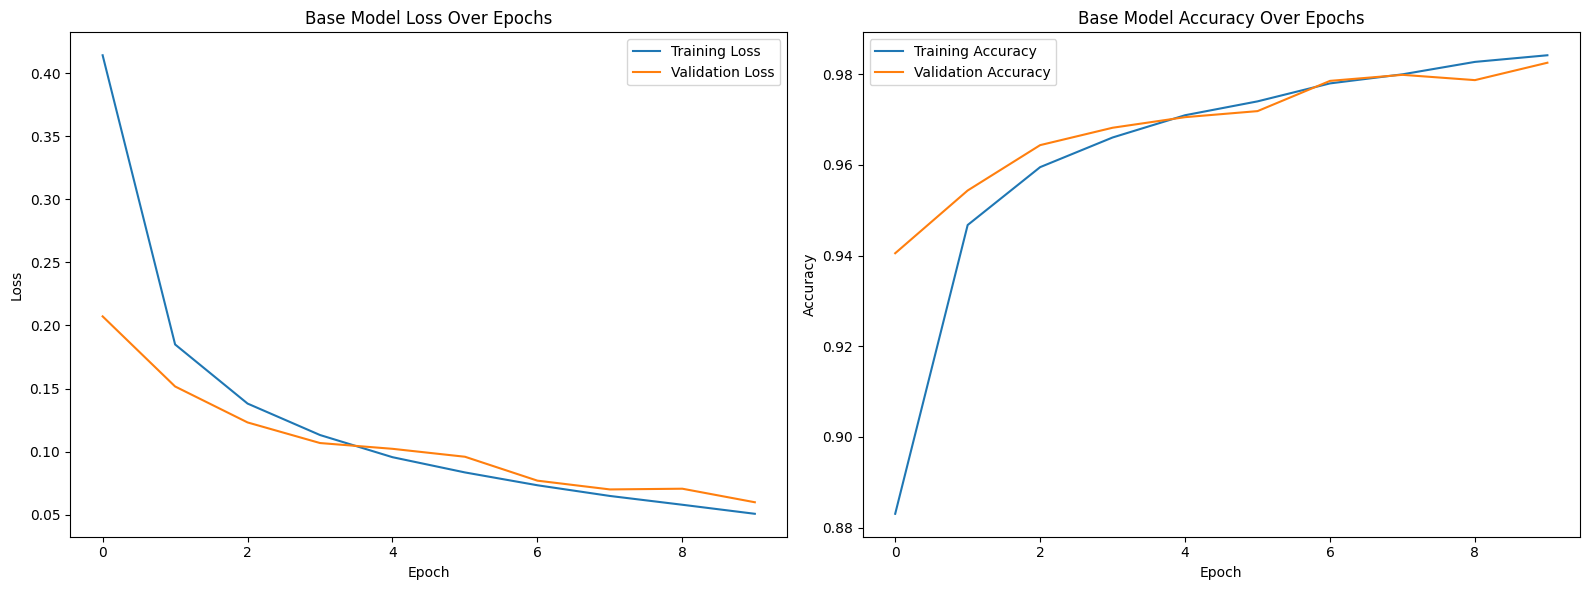

In [137]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plotting the loss metrics on the first subplot
ax1.plot(metrics_history.losses, label='Training Loss')
ax1.plot(metrics_history.val_losses, label='Validation Loss')
ax1.set_title('Base Model Loss Over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting the accuracy metrics on the second subplot
ax2.plot(metrics_history.accuracy, label='Training Accuracy')
ax2.plot(metrics_history.val_accuracy, label='Validation Accuracy')
ax2.set_title('Base Model Accuracy Over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()

From Epochs 4, we can already detect overfitting in the training. This is evident with the validation loss starting to increase while the training loss is reducing. \
The model is starting to fit extremely well with the training data but not as well with the validation data.

In [139]:
# Average training accuracy and loss accross 10 Epochs
Average_Training_loss = np.mean(metrics_history.losses)
Average_Training_accuracy = np.mean(metrics_history.accuracy)

print('Average Training loss: {0:.2f}. Average Training accuracy: {1:.2f}%'.format(Average_Training_loss, Average_Training_accuracy*100.))

Average Training loss: 0.13. Average Training accuracy: 96.25%


We have a good training accuracy of 96.25%, But we can do better than this with some hyperparameter tuning

## Hyperparameter Tuning, Manual

The following hyperparameters were adjusted

#### The width of the Neural Network
* 2 hidden layers of size 50, the accuracy increase to val_accuracy: 0.9740 with 1s on average per epochs
* 2 hidden layers of size 100, the accuracy increase to val_accuracy: 0.9808 with 1s on average per epochs
* 2 hidden layers of size 200, the accuracy increase to val_accuracy: 0.9885 with 1s on average per epochs

#### The depth of the Neural Network
* 3 hidden layers of size 200 each, the val_accuracy: 0.9860 with 2s on average per epochs, also here the val_loss has start to increase
* 4 hidden layers of size 200 each, the val_accuracy: 0.9845 with 2s on average per epochs, no visible improvement in the model.
* 4 hidden layers of size 300 each, the val_accuracy: 0.9878 with 2s on average per epochs.
* 5 hidden layers of size 300 each, the val_accuracy: 0.9828 with 2s on average per epochs.

We can conclude that the depth of the hidden layers has little effects on the network and the model, but increasing the width > 200 coupled with the depth can be an improvement

#### Activation Function
* the default activation function for the hidden layers used here is "relu"
* using "sigmoid",  the val_accuracy: 0.9725, relu is better
* using tanh, the val_accuracy: 0.9825, relu is better
* using relu and tanh, using purely relu in the hidden layers is better still!

That is because relu 'cleans' the noise in the data (think about it - if a value is negative, relu filters it out, while if it is positive, it takes it into account). For the MNIST dataset, we care only about the intensely black and white parts in the images of the digits, so such filtering proves beneficial.

The sigmoid does not filter the signals as well as relu, but still reaches a respectable result

#### Batchsize
* we started with a batch size of 100
* batchsize = 1000, increasing the batchsize reduces the optimization time, but accuracy reduces: val_accuracy: 0.9685
* batchsize = 10000, accuracy reduces: val_accuracy: 0.9053 
* batchsize = 1, the optimization time is significantly higher, with 80s on average per epochs, the accuracy is no better with val_accuracy: 0.9433, also the accuracy started high but end low and the loss can be seen to flunctuate abit.

Using a batchsize of 1 basically means we are dealing with sgd, where each data is used in optimization rather than taking a batch of the dataset like in batch-gd. this also explain the reason for the longer optimization time, since it will take a longer time to get to the minimum.
The validation accuracy starts from a high number. That's because there are lots updates in a single epoch. Once the training is over, the accuracy is lower than all other batch sizes (SGD was an approximation).

#### Learning rate
* learning rate of 0.0001, val_accuracy: 0.9608, with 4s on average per epochs. Since the learning rate is lower than normal, we may need to adjust the max_epochs (to, say, 50). The result is basically the same, but we reach it much slower.
* learning rate of 0.02, accuracy did not improve, but also the time taken was on average the same as the 0.0001.

Since adam is the chosen optimizer, it changes the learning rate per iteration by incorporating momentum to get to the gradient quicker.\
While Adam adapts to the problem, if the orders of magnitude are too different, it may not have enough time to adjust accordingly.

## Hyperparameter Selected after Manual Tuning
* BATCH_SIZE = 100
* HIDDEN_LAYER_SIZE = 200
* Number of Hidden layer = 2
* Hidden layers Activators = ReLu
* optimizer="adam", with default settings
* loss="SparseCategoricalCrossentropy"

In [172]:
# Using the hyperparameter from manual tuning

INPUT_SIZE = 784
HIDDEN_LAYER_SIZE = 200
OUTPUT_SIZE = 10

# define how the model will look like
model = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Flatten(input_shape = (28, 28, 1)),

    # Hidden layers
    tf.keras.layers.Dense(HIDDEN_LAYER_SIZE, activation="relu"), # 1st
    tf.keras.layers.Dense(HIDDEN_LAYER_SIZE, activation="relu"), # 2nd

    # the final layer is no different, we just make sure to activate it with softmax
    tf.keras.layers.Dense(OUTPUT_SIZE, activation="softmax")
])

model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=["accuracy"])

# specify the number of epochs
EPOCHS = 10

# Create an instance of your callback
metrics_history = MetricsHistory()

# we fit the model, specifying the training data, the total number of epochs
model.fit(train_data, epochs=EPOCHS, validation_data=(validation_inputs, validation_targets), verbose=0, callbacks=[metrics_history])

# Average training accuracy and loss accross 10 Epochs
Average_Training_loss = np.mean(metrics_history.losses)
Average_Training_accuracy = np.mean(metrics_history.accuracy)

print('Average Training loss: {0:.2f}. Average Training accuracy: {1:.2f}%'.format(Average_Training_loss, Average_Training_accuracy*100.))

Average Training loss: 0.07. Average Training accuracy: 98.02%


We have a good training accuracy of 98.02%, But we can do better than this with some better hyperparameter tuning strategy